In [74]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from attention import Attention
import keras_utils
from keras.utils import to_categorical
import NLP_utils
import json
from keras.backend import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split     #this is in model_selection module in newest sklearn release 0.18

In [ ]:
with open('data/signalmedia-1m.jsonl', 'r') as f:
    entry = json.loads(next(f))
    print(entry['title'])
    print(entry['content'])

In [2]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
NLP_utils.get_first_n_words(entry['content'], MAX_SEQUENCE_LENGTH)

In [3]:
with open('data/signalmedia-1m.jsonl', 'r') as f:
    count = 0
    texts = []
    summaries = []
    while count < 10000:
        entry = json.loads(next(f))
        count += 1
        texts.append(NLP_utils.get_first_n_words(entry['content'], MAX_SEQUENCE_LENGTH))
        summaries.append(NLP_utils.get_first_n_words(entry['title'], MAX_SEQUENCE_LENGTH))

In [4]:
texts[0]

"veterans saluted worcester's first ever breakfast club for ex soldiers which won over hearts, minds and bellies. the worcester breakfast club for hm forces veterans met at the postal order in foregate street at 10am on saturday. the club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. father of two dave carney, aged 43, of merrimans hill, worcester, set up the club after being inspired by other similar clubs across the country. he said as you can see from the picture, we had a good response. five out of the 10 that attended said they saw the article in the newspaper and turned up. we even had an old chap travel from droitwich and he was late on parade by three hours. it's generated a lot of interest and i estimate from other veterans who saw the article that next month's meeting will attract about 20 people. onwards and upwards. he said the management at the pub had been extremely hospitable to them. mr carne

In [5]:
summaries[0]

'worcester breakfast club for veterans gives hunger its marching orders '

In [6]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

In [ ]:
tokenizer.word_index

In [7]:
sequences = tokenizer.texts_to_sequences(texts)
sequences[0][:10]

[3470, 62, 493, 2952, 746, 7, 1828, 3226, 45, 665]

In [9]:
word2idx = tokenizer.word_index

In [8]:
idx2word = {key:val for val, key in zip(tokenizer.word_index.keys(), tokenizer.word_index.values())}


In [10]:
for word_num in sequences[0][:10]:
    print(idx2word[word_num])

veterans
first
ever
breakfast
club
for
ex
soldiers
which
won


In [11]:
input_vocab_size = 10000


In [12]:
#contstraining vocab to 10000
sequences = [np.array([i if i<input_vocab_size-1 else input_vocab_size-1 for i in s]) for s in sequences]

sequences[0][:10]

array([3470,   62,  493, 2952,  746,    7, 1828, 3226,   45,  665])

In [13]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data.shape[0]
np.arange(data.shape[0])

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [14]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [15]:
for word_num in data[0][:1000]:
    print(idx2word.get(word_num))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [16]:
embeddings_index = {}
f = open('glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
glove_embedding_dimension = 50


In [18]:
truncated_word_index = {key: value for key, value in word2idx.items() if value < 10000}
print(len(truncated_word_index))
embedding_matrix = np.zeros((len(truncated_word_index) + 1, glove_embedding_dimension))
for word, i in truncated_word_index.items():
    # use .get() so that it'll return None if the word isn't in the index rather than raising key exception
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

9999


In [19]:
embedding_matrix[1]

array([  4.18000013e-01,   2.49679998e-01,  -4.12420005e-01,
         1.21699996e-01,   3.45270008e-01,  -4.44569997e-02,
        -4.96879995e-01,  -1.78619996e-01,  -6.60229998e-04,
        -6.56599998e-01,   2.78430015e-01,  -1.47670001e-01,
        -5.56770027e-01,   1.46579996e-01,  -9.50950012e-03,
         1.16579998e-02,   1.02040000e-01,  -1.27920002e-01,
        -8.44299972e-01,  -1.21809997e-01,  -1.68009996e-02,
        -3.32789987e-01,  -1.55200005e-01,  -2.31309995e-01,
        -1.91809997e-01,  -1.88230002e+00,  -7.67459989e-01,
         9.90509987e-02,  -4.21249986e-01,  -1.95260003e-01,
         4.00710011e+00,  -1.85939997e-01,  -5.22870004e-01,
        -3.16810012e-01,   5.92130003e-04,   7.44489999e-03,
         1.77780002e-01,  -1.58969998e-01,   1.20409997e-02,
        -5.42230010e-02,  -2.98709989e-01,  -1.57490000e-01,
        -3.47579986e-01,  -4.56370004e-02,  -4.42510009e-01,
         1.87849998e-01,   2.78489990e-03,  -1.84110001e-01,
        -1.15139998e-01,

In [20]:
MAX_SUMMARY_LENGTH = 20

In [21]:
y_summaries = tokenizer.texts_to_sequences(summaries)
y_summaries[0][:10]

[7825, 2952, 746, 7, 3470, 1347, 5897, 49, 2640]

In [22]:
output_vocab_size = 10000

In [23]:
#contstraining vocab to 10000
y_summaries = [np.array([i if i<output_vocab_size-1 else output_vocab_size-1 for i in s]) for s in y_summaries]
y_summaries[0][:10]

array([7825, 2952,  746,    7, 3470, 1347, 5897,   49, 2640])

In [24]:
for word_num in y_summaries[0][:21]:
    print(idx2word.get(word_num))

worcester
breakfast
club
for
veterans
gives
hunger
its
orders


In [25]:
y_summaries = pad_sequences(y_summaries, maxlen=MAX_SUMMARY_LENGTH, padding='post', truncating='post')
y_summaries.shape[0]
np.arange(y_summaries.shape[0])

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [26]:
for word_num in y_summaries[0][:21]:
    print(idx2word.get(word_num))

worcester
breakfast
club
for
veterans
gives
hunger
its
orders
None
None
None
None
None
None
None
None
None
None
None


In [27]:
# go_token = word2idx["*"]
# make second to last word in index the go token
dec_input_ = np.concatenate([np.ones((len(y_summaries),1)) * 9998, y_summaries[:,:-1]], axis=1)

In [28]:
dec_input_[3]

array([ 9998.,    19.,    39.,  4477.,   850.,    24.,    54.,   866.,
         151.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.])

In [29]:
(input_train, input_test, labels_train, labels_test, dec_input_train, dec_input_test) = train_test_split(data, y_summaries, dec_input_, test_size=0.1)

In [30]:
input_train.shape

(9000, 1000)

In [31]:
labels_train.shape

(9000, 20)

In [32]:
def get_rnn(return_sequences= True): 
    return LSTM(dim, dropout_U= 0.1, dropout_W= 0.1, 
                implementation=2, return_sequences=return_sequences)

In [33]:
dim = 240
inp = Input((MAX_SEQUENCE_LENGTH,))
inp_dec = Input((MAX_SUMMARY_LENGTH,))
emb_dec = Embedding(output_vocab_size, glove_embedding_dimension, input_length=MAX_SUMMARY_LENGTH, weights=[embedding_matrix], trainable=False)(inp_dec)
emb_dec = Dense(dim)(emb_dec)

x = Embedding(input_vocab_size, glove_embedding_dimension, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(get_rnn())(x)
x = get_rnn()(x)
x = get_rnn()(x)
x = Attention(get_rnn, 3)([x, emb_dec])
x = TimeDistributed(Dense(output_vocab_size, activation='softmax'))(x)

/home/javed/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(240, implementation=2, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)`
  app.launch_new_instance()


In [34]:
model = Model([inp, inp_dec], x)
model.compile(Adam(), 'categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

In [35]:
#parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
lstm_params = {}

In [53]:
def gen(input_data, dec_data, labels, batch_size):
    batch_end_ptr = 0
    while True:
        batch_begin_ptr = batch_end_ptr
        batch_end_ptr += batch_size
        # if we made the batch end pointer go off the edge of the array, set it back to the beginning
        if batch_end_ptr >= len(input_data):
            batch_end_ptr = min(batch_size, len(input_data) - 1)
            batch_begin_ptr = 0
        
        # take samples between the two pointers as the batch
        input_batch = input_data[batch_begin_ptr:batch_end_ptr]
        dec_batch = dec_data[batch_begin_ptr:batch_end_ptr]
        labels_batch = np.array([to_categorical(ex, 10000) for ex in labels[batch_begin_ptr:batch_end_ptr]])

        yield ([input_batch, dec_batch], labels_batch)

In [54]:
batch_size = 64

In [55]:
train_gen = gen(input_train, dec_input_train, labels_train, batch_size)
val_gen = gen(input_test, dec_input_test, labels_test, batch_size)

In [56]:
hist=model.fit_generator(train_gen, steps_per_epoch=len(input_train)/batch_size, validation_data=val_gen, validation_steps=len(input_test)/batch_size, epochs=1)

Epoch 1/1
141/140 [==============================] - 450s - loss: 3.9451 - acc: 0.6041 - val_loss: 3.2401 - val_acc: 0.6068


In [57]:
hist2=model.fit_generator(train_gen, steps_per_epoch=len(input_train)/batch_size, validation_data=val_gen, validation_steps=len(input_test)/batch_size, epochs=3)

Epoch 1/3
141/140 [==============================] - 439s - loss: 3.1662 - acc: 0.6095 - val_loss: 3.2075 - val_acc: 0.6080
Epoch 2/3
141/140 [==============================] - 446s - loss: 3.1348 - acc: 0.6106 - val_loss: 3.1919 - val_acc: 0.6108
Epoch 3/3
141/140 [==============================] - 440s - loss: 3.1204 - acc: 0.6106 - val_loss: 3.1922 - val_acc: 0.6103


In [58]:
import matplotlib.pyplot as plt

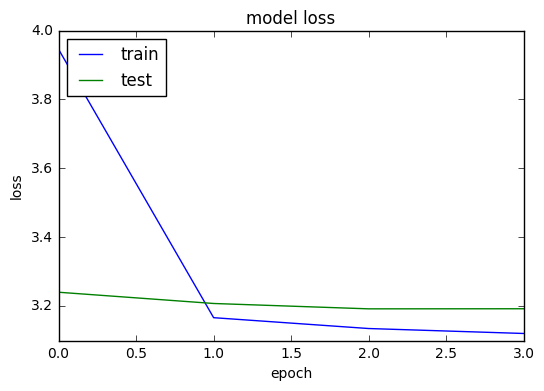

In [59]:
plt.plot(hist.history['loss'] + hist2.history['loss'])
plt.plot(hist.history['val_loss']+ hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
test = model.predict([input_test[:20], dec_input_test[:20]])

In [72]:
test1, test2 = test[0], test[1]

In [84]:
np.argmax(test1, axis=-1)

array([1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
for summ in test:
   print([idx2word[word] for word in np.argmax(summ, axis=-1) if word != 0])

['the', 'to', 'to']
['the']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']
['the', 'to', 'to']


'the'

In [ ]:
hist=model.fit([input_train, dec_input_train], labels_train, 
          validation_data=[[input_test, dec_input_test], labels_test], 
          batch_size=64, epochs=10)

In [ ]:
hist.history['val_loss']

In [ ]:
# reduce learning rate before continuing
K.set_value(model.optimizer.lr, 1e-4)

In [ ]:
hist=model.fit([input_train, dec_input_train], np.expand_dims(labels_train,-1), 
          validation_data=[[input_test, dec_input_test], np.expand_dims(labels_test,-1)], 
          batch_size=64, **parms, nb_epoch=5)

In [ ]:
dec_input_test.shape
np.expand_dims(labels_train,-1).shape

In [ ]:
labels_train = np.array([to_categorical(ex, 10000) for ex in labels_train])

In [ ]:
len(labels_train[0][0])

In [ ]:
labels_test = np.array([to_categorical(ex, 10000) for ex in labels_test])